## Stock Analysis and Forecasting - LSTM Model

In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

aapl=yf.download('AAPL',start='2015-01-01',end='2025-12-31')
aapl= aapl[['Open', 'High', 'Low', 'Close', 'Volume']]
aapl.dropna(inplace=True)

scaler = MinMaxScaler()
aapl = scaler.fit_transform(aapl)
aapl
# 25.81 at 75
# 79.05 at 80
# 24.88 on 30
# 16.44 on 1
# 26.52 on 4
# 27.87 on 18
# 25.97 at 19
# barbaad 5,6,7,8,9

[*********************100%***********************]  1 of 1 completed


array([[0.01762237, 0.01595618, 0.01437298, 0.01531499, 0.3030476 ],
       [0.01471649, 0.01335759, 0.0125511 , 0.01243697, 0.37389842],
       [0.01307607, 0.01222129, 0.01181859, 0.01244631, 0.38356353],
       ...,
       [0.79899198, 0.79639636, 0.79087868, 0.7906337 , 0.02494507],
       [0.79599623, 0.80050496, 0.79671228, 0.79269472, 0.03046977],
       [0.80055322, 0.8026431 , 0.79552866, 0.79711115, 0.0386753 ]],
      shape=(2649, 5))

In [42]:
# Define lookback window (e.g., 30 days)
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])        # shape = (time_steps, n_features)
        y.append(data[i, 3])  # Predict 'Close' (index 3)
    return np.array(X), np.array(y)

time_steps =5
X, y = create_dataset(aapl, time_steps)

# Train/Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Toh sir jo future predictions hoti hai uska basis kya hota hai aur unhe kaise kara jaata hai accurately, kya use karte hain kyunki multi step ahead ki predictions mujhe pata chala toh kaafi deviated hoti hai actual results se, kya use kar skte hain


In [43]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility setup
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()


In [44]:
# 🏗 Build the model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Regularization
model.add(Dense(1))      # Output layer for regression
model.compile(optimizer='adam', loss='mean_squared_error')

# 🛑 Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [45]:
# 🏋️‍♂️ Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
45/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083
Epoch 1: val_loss improved from None to 0.00039, saving model to best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0028 - val_loss: 3.8981e-04
Epoch 2/30
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9124e-04
Epoch 2: val_loss improved from 0.00039 to 0.00038, saving model to best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.9166e-04 - val_loss: 3.7631e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2939e-04
Epoch 3: val_loss did not improve from 0.00038
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0960e-04 - val_loss: 5.7356e-04
Epoch 4/30
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3658e-04
Epoch 4: val_loss did not improve from 0.00038
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1976e-04 - val_loss: 3.9540e-04


In [46]:
best_model = load_model('best_model.h5')

In [47]:
y_pred = best_model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [48]:
def rescale(pred, original_data):
    pad = np.zeros((len(pred), original_data.shape[1]))
    pad[:, 3] = pred.flatten()  # assuming 'Close' is at index 3
    return scaler.inverse_transform(pad)[:, 3]

y_test_rescaled = rescale(y_test, aapl)
y_pred_rescaled = rescale(y_pred, aapl)

Test MSE: 31.50
R2: 0.94


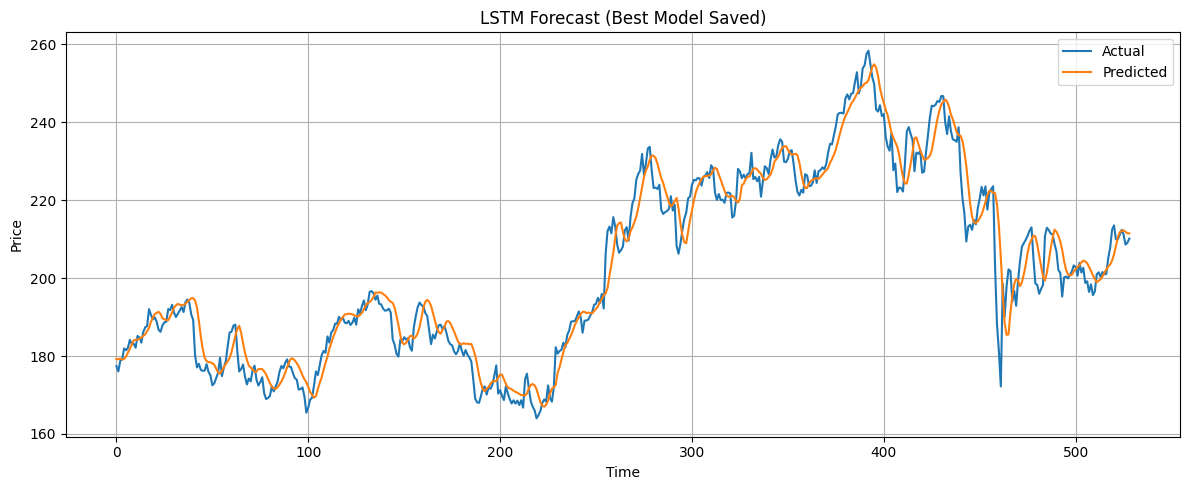

In [49]:
# Evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("LSTM Forecast (Best Model Saved)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Adjusted r2, try multistep with vanilla then with encoder decoder, Report - Introduction, Tasks, results, learning